Function for better embedding:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform, RampWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
import scipy
import networkx as nx
from scipy import stats
from numpy.random import default_rng
import matplotlib as mpl
# import dimod
from typing import Optional

from scipy.optimize import NonlinearConstraint, minimize
from scipy.spatial.distance import pdist
from skopt import gp_minimize

from parseprovider import parseprovider
from master import masterproblem
from gen_Q import gen_Q

In [2]:
def replace_embedding(pos, 
    device: Chadoq2
    )-> np.ndarray:

    min_atom_distance = device.min_atom_distance
    max_radial_distance = device.max_radial_distance
    n = len(pos)

    xmax = max_radial_distance / np.sqrt(2)
    bounds = [(-xmax, xmax)] * (2 * n)
    scale = np.max([np.sqrt(x.dot(x)) for x in pos])
    pos *= xmax / scale

    # constraint for minimal distance between atoms
    x0 = pos.reshape(2 * n)
    dmin = 1.1 * min_atom_distance
    nlc = NonlinearConstraint(lambda x0: pdist(x0.reshape(n, 2)).min(), dmin, np.inf)
    res = minimize(lambda xs: 1, x0=x0, bounds=bounds, constraints=nlc, method="SLSQP")

    # scale coordinates to occupy as much of the available space as possilbe
    pos = res.x.reshape(n, 2)
    scale_diameter = 0.95 * max_radial_distance / pdist(pos).max()
    pos *= max(scale_diameter, 1.0)
    pos -= pos.mean(axis=0)

    return pos

def qubo_matrix_distance(Q1, Q2):
    return scipy.spatial.distance.jensenshannon(Q1.flatten(), Q2.flatten())

#objective function for minimizer
def evaluate_mapping(coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""

    Qn, shape, device = args
    # Q_max = np.max(Qn)
    coords = np.reshape(coords, shape)
    new_Q = squareform(device.interaction_coeff / pdist(coords) ** 6)
    # Q_new_max = np.max(new_Q)
    # Qn *= Q_new_max/Q_max
    # return np.linalg.norm(new_Q - Qn, ord = 'fro')
    return qubo_matrix_distance(Qn, new_Q)

def register_basic_embedding_QUBO(
    Qn,
    device: Chadoq2,
):
    """Fit the previously available node coordinates to run them on the hardware"""


    #Q matrix: 
    #now, do the iterations to minimize using Nelder-Mead
    shape = (len(Qn), 2)
    # np.random.seed(0)
    max_radial_distance = device.max_radial_distance
    bounds = [(-max_radial_distance, max_radial_distance) for k in range(2*len(Qn))]
    keep_going = True
    N_iter = 10
    it = 0

    ####
    graph = nx.from_numpy_array(Qn)
    new_coords = np.array(list(nx.spring_layout(graph).values()))
    new_coords -= new_coords.mean(axis=0)

    #function to rescale, constrain, and center:
    new_coords = replace_embedding(new_coords, device)
    ####
    x0 = new_coords.flatten()
    initial_func_eval = evaluate_mapping(x0, *(Qn, shape, device))

    while keep_going:
        new_coords = np.array(list(nx.spring_layout(graph).values()))
        new_coords -= new_coords.mean(axis=0)

        #function to rescale, constrain, and center:
        new_coords = replace_embedding(new_coords, device)

        #thus, the fitting to the parameters is easier
        res = minimize(
                evaluate_mapping,
                x0,
                args=(Qn, shape, device),
                bounds= tuple(bounds),
                method="Nelder-Mead",
                tol=1e-6,
                options={"maxiter": 200000, "maxfev": 100000},
            )
        final_func_eval = evaluate_mapping(res.x, *(Qn, shape, device))

        new_coords = np.reshape(res.x, (len(Qn), 2))
        x0 = res.x
        # then rescale
        new_coords = replace_embedding(new_coords, device)
        
        if (it > N_iter):
            # print('too many iterations')
            keep_going = False
        if res.success:
            # print('success in minimizer')
            keep_going = False

        it += 1

    R_min = np.min(pdist(new_coords))

    seq_omega_max = 2 * 2 * np.pi/2
    r_min_theo = device.rydberg_blockade_radius(2*seq_omega_max)

    #scale the register following this R1/R2 argument
    new_pos = np.array(new_coords)
    new_pos *= r_min_theo/R_min
    new_pos -= np.mean(new_pos, axis=0)
    

    return new_pos


 example qubo

In [3]:
input_file = 'data/edisp_10.txt';
N,D,cost,xmin,xmax = parseprovider(input_file)

In [4]:
# Qtest = np.array([[0, 10, 5, 0], [10, 0, 10, 3], [5, 10, 0, 7], [3, 0, 7, 0]])
# print(Qtest)
Qtest = gen_Q(xmax)
Qtest

array([[ 0.        , 11.74545455, 13.18181818, 11.85454545,  9.23636364,
        12.49090909, 10.54545455, 10.25454545, 15.72727273, 20.        ],
       [11.74545455,  0.        ,  8.18793706,  7.3634965 ,  5.7372028 ,
         7.75877622,  6.55034965,  6.36965035,  9.76905594, 12.42307692],
       [13.18181818,  8.18793706,  0.        ,  8.26398601,  6.43881119,
         8.7076049 ,  7.3513986 ,  7.1486014 , 10.96372378, 13.94230769],
       [11.85454545,  7.3634965 ,  8.26398601,  0.        ,  5.79048951,
         7.83083916,  6.61118881,  6.42881119,  9.85979021, 12.53846154],
       [ 9.23636364,  5.7372028 ,  6.43881119,  5.79048951,  0.        ,
         6.10132867,  5.15104895,  5.00895105,  7.68216783,  9.76923077],
       [12.49090909,  7.75877622,  8.7076049 ,  7.83083916,  6.10132867,
         0.        ,  6.96608392,  6.77391608, 10.38907343, 13.21153846],
       [10.54545455,  6.55034965,  7.3513986 ,  6.61118881,  5.15104895,
         6.96608392,  0.        ,  5.71888112

finding the coordinates

In [5]:
coords = register_basic_embedding_QUBO(Qtest, Chadoq2)

drawing it out

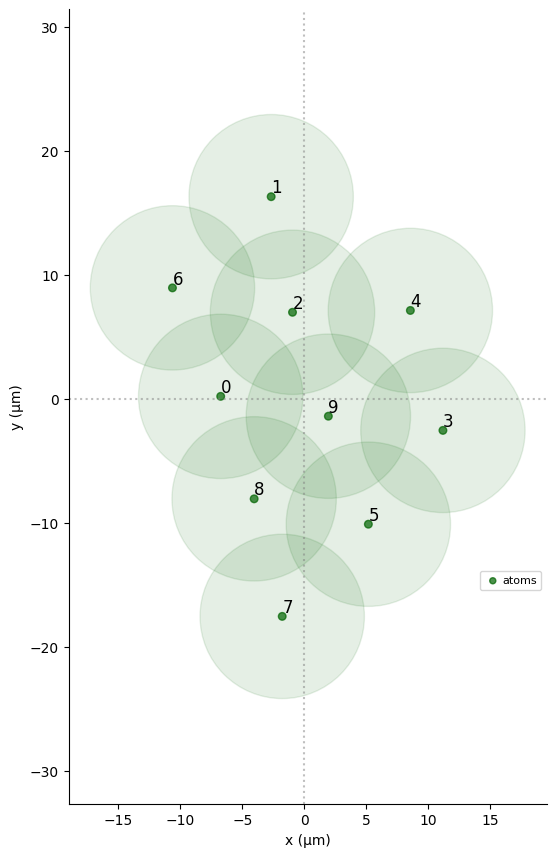

In [6]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

From here down:

In [7]:
# def gen_Q(x_maxes):
#     n = len(x_maxes)
    
#     Q = np.zeros((n, n))

#     for i in range(n):
#         for j in range(n):
#             if i == j:
#                 Q[i][j] = 0
#             else:
#                 Q[i][j] = x_maxes[i] * x_maxes[j]
                
#     # Rescale the matrix such that max value is 20
#     max_value = np.max(Q)
#     if max_value != 0:
#         scale_factor = 20.0 / max_value
#         Q *= scale_factor

#     return Q


def create_interp_pulse(amp_params, det_params):
        T = 4000
        delta_0 = -10
        return Pulse(
            InterpolatedWaveform(T, [1e-9, *amp_params, 1e-9]),
            InterpolatedWaveform(T, [delta_0, *det_params]),
            0,
        )


example generated pulse

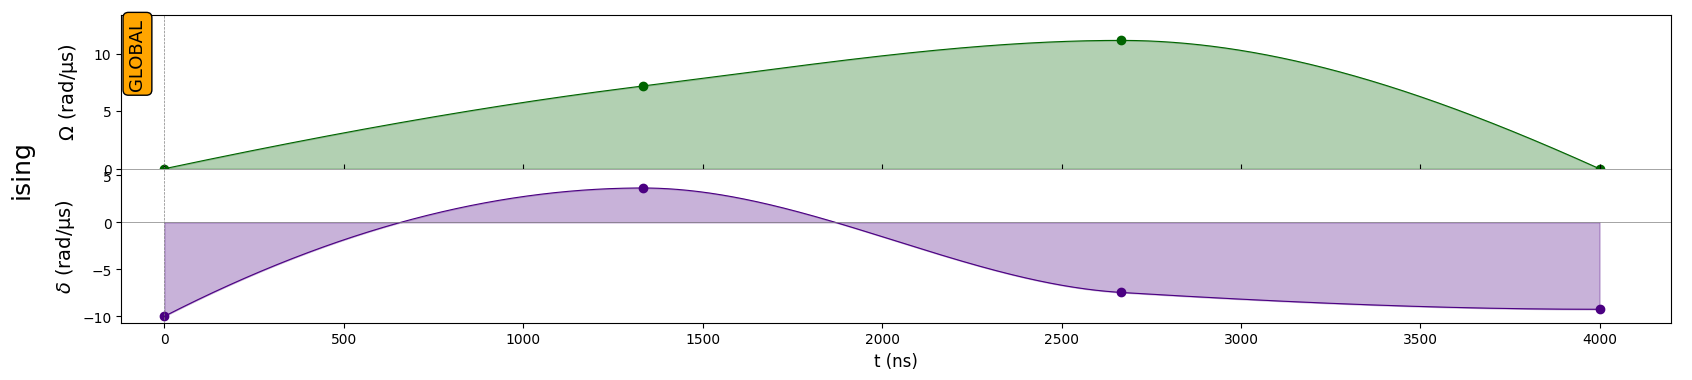

In [8]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
m=2
Omega_max = 2 * 2 * np.pi
delta_0 = -10
delta_f_max = 10
#initial params for the search
amp_params = np.random.uniform(0, Omega_max, m)
det_params = np.random.uniform(delta_0, delta_f_max, m + 1)
seq.add(create_interp_pulse(amp_params, det_params), "ising")
seq.draw()

In [9]:
def run_cycle(xs, demand):

    qubo = gen_Q(xs)
    coords = register_basic_embedding_QUBO(qubo, Chadoq2)
    qubits = dict(enumerate(coords))
    reg = Register(qubits)
    #now you have a register

    #pulse parameters
    m = 2
    Omega_max = 2 * 2 * np.pi
    delta_0 = -10
    delta_f_max = 10
    #initial params for the search
    amp_params = np.random.uniform(0, Omega_max, m)
    det_params = np.random.uniform(delta_0, delta_f_max, m + 1)
    #bounds of the whole search
    bounds = [(0.0, Omega_max)] * m + [(delta_0, delta_f_max)] * m


    params = list(amp_params) + list(det_params)
    # print(params)


    def run_qubo(params):
        #params = amp_params, det_params
        seq = Sequence(reg, Chadoq2)
        seq.declare_channel("ising", "rydberg_global")
        seq.add(create_interp_pulse(params[:m], params[m:]), "ising")

        #result
        simul = QutipEmulator.from_sequence(seq)
        N_samples = 200
        results = simul.run()
        count_dict = results.sample_final_state(N_samples=N_samples)

        #check if any of the solutions respect the constraint
        most_freq = [k for k, v in count_dict.items() if v > 10]
        vals = []
        for bitstring in most_freq:
            value = - demand
            for i in range(len(bitstring)):
                value += xs[i]*int(bitstring[i])
            vals.append(value**2)

        ind = np.argmin(vals)
        min_val = vals[ind]
        # min_string = most_freq[ind]

        return min_val

    #general parameters


    bounds = [(0.0, Omega_max)] * m + [(delta_0, delta_f_max)] * (m +1)
    # print(bounds)

    # n_r = 30
    # n_c = 120


    # # RESULT = gp_minimize(
    # #     run_qubo, bounds, n_random_starts=n_r, n_calls=n_c, verbose=True
    # # )

    RESULT = minimize(run_qubo, x0 = params, bounds = bounds, options={'maxiter': 20})

    

    #run that good pulse one more time
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    P = create_interp_pulse(RESULT.x[:m], RESULT.x[m:])
    # P = create_interp_pulse(params[:m], params[m:])
    seq.add(P, "ising")
    simul = QutipEmulator.from_sequence(seq)
    N_samples = 2000
    results = simul.run()
    count_dict = results.sample_final_state(N_samples=N_samples)
    

    #check if any of the solutions respect the constraint
    most_freq = [k for k, v in count_dict.items() if v > 10]
    # print(most_freq)
    good_strings = []
    vals = []
    for bitstring in most_freq:
        value = - demand
        for i in range(len(bitstring)):
            value += xs[i]*int(bitstring[i])
        if value >= 0:
            vals.append(value)
            good_strings.append(bitstring)

    # ind = np.argmin(vals)
    # min_val = vals[ind]
    # min_string = most_freq[ind]

    return good_strings, RESULT.x[:m], RESULT.x[m:], coords

example

In [10]:
input_file = 'data/edisp_10.txt';
N,D,cost,xmin,xmax = parseprovider(input_file)

In [11]:
# xmax = [15, 5, 40, 30]
# D = 50

good_strings, omega_list, delta_list, coords = run_cycle(xmax, D)

# convert to list[list[ints]]
results = [[int(bit) for bit in b] for b in good_strings]
print(results)

[[0, 1, 1, 1, 1, 0, 0, 0, 1, 1], [1, 0, 0, 1, 0, 1, 1, 1, 0, 1], [1, 0, 0, 1, 1, 1, 1, 1, 0, 1]]


maximal pulse

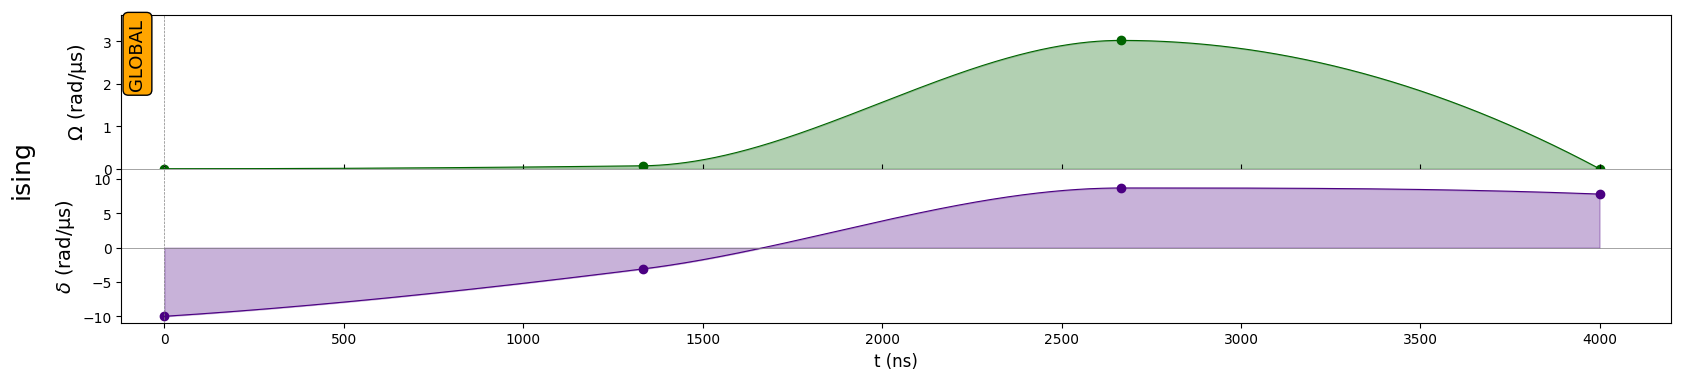

In [12]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(create_interp_pulse(omega_list, delta_list), "ising")
seq.draw()

register

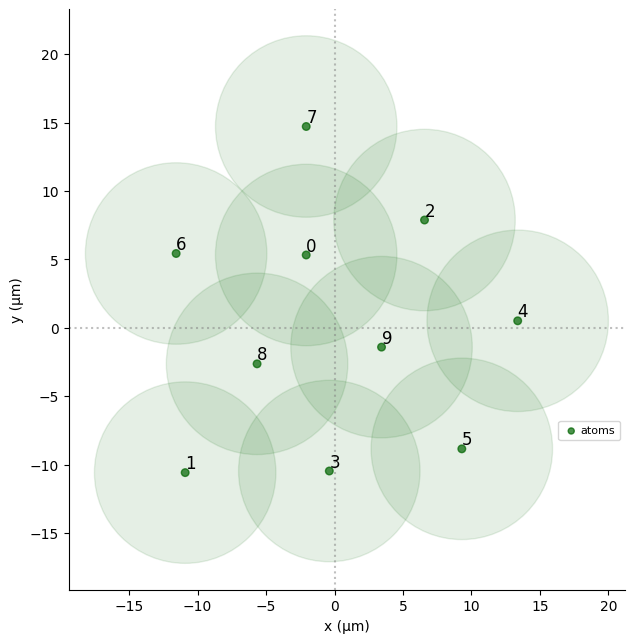

In [13]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [14]:
# check these solution to min(sum c_i x)
fun_vals = []

for u in results:
    res = masterproblem(u,N,D,cost,xmin,xmax)
    fun_vals.append(res.fun)
print(fun_vals)

[8000.0, 8000.0, 7999.999999999999]


In [15]:
min_value, index = min((val, idx) for idx, val in enumerate(fun_vals))
print("best solution: ", results[index])
print("cost: ", min_value)

best solution:  [1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
cost:  7999.999999999999
